<a href="https://colab.research.google.com/github/apoorvap11/RML--Group-6/blob/main/assign_3__Group6_SEED_10001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021 - 2025 Patrick Hall (jphall@gwu.edu), Apoorva Paranthaman (apoorvap@gwu.edu), Maryam Shabhaz Ali (maryamshahbaz.ali@gwmail.gwu.edu), Zahra Sultani (zahra.sultani@gwmail.gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 3  

#### Group members:
1. Apoorva Paranthaman
2. Maryam Shahbaz Ali
3. Zahra Sultani


# Testing and Remediating Bias in an XGBoost Credit Model

### Contents

1. [Colab and Environment Preliminaries](#colab-and-environment-preliminaries)
2. [Training and Evaluating an XGBoost Model](#train)
3. [Bias Testing](#test)
4. [Remediating Model Bias](#remed)


## <a name=colab-and-environment-preliminaries></a>1. Colab and Environment Preliminaries


#### Install packages  

In [ ]:
!pip install h2o
!pip install interpret
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━

###  Imports and Setup

In [ ]:
import datetime                                               # timestamp for submission file
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # for plots
import numpy as np                                            # for basic array manipulation
import pandas as pd                                           # for dataframe manipulation
import random                                                 # to sample from lists
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs
import time                                                   # for timers

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

### Define utility functions

#### Utility function to calculate confusion matrices by demographic group

In [ ]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

#### Utility function to calculate AIR

In [ ]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


#### Utility function to select probability cutoff by F1

In [ ]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for i, cut in enumerate(np.arange(0, 1 + res, res)):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

    del temp_df

    return f1_frame

#### Utility function for random grid search

In [ ]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            row_dict['features'] = ', '.join(row_dict['features'])
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame

#### Start global timer

In [ ]:
tic = time.time()

#### Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/DNSC_6330_Software/

Mounted at /content/drive/
/content/drive/My Drive/DNSC_6330_Software


In [ ]:
import os

for root, dirs, files in os.walk('/content'):
    for name in files:
        if 'hmda' in name:
            print("✅ Found:", os.path.join(root, name))


✅ Found: /content/drive/MyDrive/data/hmda_train_preprocessed.csv
✅ Found: /content/drive/MyDrive/data/hmda_test_preprocessed.csv
✅ Found: /content/drive/MyDrive/DNSC_6330_Software/data/hmda_train_preprocessed.csv
✅ Found: /content/drive/MyDrive/DNSC_6330_Software/data/hmda_test_preprocessed.csv


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/DNSC_6330_Software/data/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/DNSC_6330_Software/data/hmda_test_preprocessed.csv')


#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable model

#### Split data into train and validation partitions

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Fit EBM with random grid search

#### fname code addition

In [ ]:

SEED = 10001

# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12],
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm, ebm_grid_frame = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=50,
                                    early_stopping_rounds=100, seed=SEED)


fname = 'ebm_grid_frame_' + str(SEED) + '.csv'
ebm_grid_frame.to_csv(fname, index=False)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-6-0a10eb72a23e>:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


Grid search new best score discovered at iteration 1/50: 0.8230.
---------- ----------
Grid search run 2/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 3/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 3/50: 0.8236.
---------- ----------
Grid search run 4/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'i

In [ ]:
fname = 'ebm_grid_frame_' + str(SEED) + '.csv'
ebm_grid_frame.to_csv(fname, index=False)

from google.colab import files
files.download(fname)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
os.listdir()

['data',
 'ebm_grid_frame_77777.csv',
 'ebm_grid_frame_67891.csv',
 'ebm_grid_frame_10001.csv']

#### Basic AUC assessment

In [ ]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8248.


#### Score validation data with model

In [ ]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.176456
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.284826
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.026125
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015306
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.003537


### Investigate Best Model (EBM) for Discrimination

#### Find optimal cutoff based on F1
Cutoffs are normally selected by maximizing a quality statistic or a business metric, and not by considering bias and discrimination.

In [ ]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

<ipython-input-5-27fa63c62f51>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.230808  0.373193
2    0.02  0.260332  0.472933
3    0.03  0.279503  0.526526
4    0.04  0.294116  0.565665
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3653 achieved at cutoff: 0.18 with accuracy: 0.7952.


#### Find confusion matrices for demographic groups

In [ ]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       460       885
predicted: 0       204      1643

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        99       185
predicted: 0        49      2917

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1927      5992
predicted: 0      1238     25368

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1027      3076
predicted: 0       637     11092

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       831      2145
predicted: 0       409      6647



#### Find AIR for Asian people

In [ ]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.771
Asian proportion accepted: 0.913
Adverse impact ratio for Asian people vs. White people: 1.184


#### Find AIR for Black people

In [ ]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.771
Black proportion accepted: 0.579
Adverse impact ratio for Black people vs. White people: 0.751


#### Find AIR for Females

In [ ]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.741
Female proportion accepted: 0.703
Adverse impact ratio for Females vs. Males: 0.949


### Attempt remediation of discovered discrimination

#### Simplest remediation: Find cutoff with better Black vs. White AIR

In [ ]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

<ipython-input-5-27fa63c62f51>:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


,cut,f1,acc,air
21,0.21,0.360059,0.827535,0.805596
22,0.22,0.355160,0.837184,0.825767
23,0.23,0.348119,0.847187,0.849980
24,0.24,0.334189,0.854320,0.867767
25,0.25,0.324505,0.861558,0.886508


Cutoffs in the 0.22-0.26 range provide increased accuracy and less bias towards Black people.

#### Check that other groups are not adversely impacted by change

In [ ]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.116
Adverse impact ratio for Black people vs. White people: 0.826
Adverse impact ratio for Females vs. Males: 0.965


The new cutoff does not adversely affect other protected groups.

#### More sophisticated remdiation: Model selection via quality and fairness

In [ ]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=25,
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black',
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}


<ipython-input-6-0a10eb72a23e>:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


Grid search new best score discovered at iteration 1/25: 0.6473.
---------- ----------
Grid search run 2/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 3/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 3/25: 0.7277.
---------- ----------
Grid search run 4/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 10001, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'i

### Reweightning Remediation Method

In [ ]:
import numpy as np
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# Function to reweight the dataset
def reweight_dataset(frame, y, demo_name, groups):
    n = len(frame)
    freq_dict = {'pos': len(frame.loc[frame[y] == 1])/n,
                 'neg': len(frame.loc[frame[y] == 0])/n}
    freq_dict.update({group: frame[demo_name].value_counts()[group]/n for group in groups})
    weights = pd.Series(np.ones(n), index=frame.index)
    for label in [0, 1]:
        for group in groups:
            label_name = 'pos' if label == 1 else 'neg'
            freq = frame.loc[frame[y] == label][demo_name].value_counts()[group]/n
            weights[(frame[y] == label) & (frame[demo_name] == group)] *= freq_dict[group]*freq_dict[label_name]/freq
    return weights

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DNSC_6330_Software/data/hmda_train_preprocessed.csv')
test = pd.read_csv('/content/drive/MyDrive/DNSC_6330_Software/data/hmda_test_preprocessed.csv')

y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


In [ ]:
# Split data into train and validation partitions
np.random.seed(12345)  # preserve exact reproducibility for this cell
split_ratio = 0.7  # 70%/30% train/test split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

In [ ]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']

In [ ]:
# Create a combined race column
def combine_race_columns(row):
    if row['black'] == 1:
        return 'black'
    elif row['asian'] == 1:
        return 'asian'
    elif row['white'] == 1:
        return 'white'
    else:
        return 'other'

data['race'] = data.apply(combine_race_columns, axis=1)
test['race'] = test.apply(combine_race_columns, axis=1)

# Verify the columns
print("Data columns:", data.columns)
print("Test columns:", test.columns)

# Verify the 'race' column
print("Data 'race' column:\n", data['race'].head())
print("Test 'race' column:\n", test['race'].head())

# Print the first few rows of the DataFrame
print("Data DataFrame:\n", data.head())
print("Test DataFrame:\n", test.head())

# Define the reweight_dataset function (assuming it is defined)
def reweight_dataset(df, y_name, group_name, group_levels):
    # Placeholder for the actual reweighting logic
    # This function should return the sample weights for the dataset
    return pd.Series([1] * len(df))

# Define the race levels
race_levels = ['black', 'asian', 'white', 'other']

Data columns: Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced', 'race'],
      dtype='object')
Test columns: Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'race'],
      dtype='object')
Data 'race' column:
 0    other
1    white
2    other
3    white
4    white
Name: race, dtype: object
Test 'race' column:

In [ ]:
# Apply reweighting
train_weights = reweight_dataset(train, y_name, 'race', race_levels)

# Train EBM model on reweighted data



In [ ]:
# Create a combined race column
def combine_race_columns(row):
    if row['black'] == 1:
        return 'black'
    elif row['asian'] == 1:
        return 'asian'
    elif row['white'] == 1:
        return 'white'
    else:
        return 'other'

data['race'] = data.apply(combine_race_columns, axis=1)
test['race'] = test.apply(combine_race_columns, axis=1)

# Verify the columns
print("Data columns:", data.columns)
print("Test columns:", test.columns)

# Verify the 'race' column
print("Data 'race' column:\n", data['race'].head())
print("Test 'race' column:\n", test['race'].head())

# Print the first few rows of the DataFrame
print("Data DataFrame:\n", data.head())
print("Test DataFrame:\n", test.head())

# Define the reweight_dataset function (assuming it is defined)
def reweight_dataset(df, y_name, group_name, group_levels):
    # Placeholder for the actual reweighting logic
    # This function should return the sample weights for the dataset
    return pd.Series([1] * len(df))

# Define the race levels
race_levels = ['black', 'asian', 'white', 'other']

# Apply reweighting
train_weights = reweight_dataset(data, y_name, 'race', race_levels)

# Train EBM model on reweighted data
ebm = ExplainableBoostingClassifier(random_state=12345)
ebm.fit(data[x_names], data[y_name], sample_weight=train_weights)

# Evaluate the model on the test set
test_predictions = ebm.predict(test[x_names])
print("Test Predictions:\n", test_predictions)

Data columns: Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced', 'race'],
      dtype='object')
Test columns: Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'race'],
      dtype='object')
Data 'race' column:
 0    other
1    white
2    other
3    white
4    white
Name: race, dtype: object
Test 'race' column:

In [ ]:
# Evaluate model
best_ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

# Score validation data with model
best_ebm_phat = pd.DataFrame(ebm.predict_proba(valid[x_names])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

Validation AUC: 0.8293.


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.193981
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.298166
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.026406
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.013517
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.003582


In [ ]:
# Find optimal cutoff based on F1
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):
    do_air = all(v is not None for v in [air_reference, air_protected])
    columns = ['cut', 'f1', 'acc', 'air'] if do_air else ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=columns)
    temp_df = frame[[y, yhat]].copy(deep=True)
    for i, cut in enumerate(np.arange(0, 1 + res, res)):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
        f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)
    del temp_df
    return f1_frame

f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')
print(f1_frame)
print()
max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut']
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']
print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

<ipython-input-35-dc5861e1d7e7>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.234799  0.387314
2    0.02  0.263545  0.479879
3    0.03  0.282229  0.532557
4    0.04  0.297774  0.571654
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3687 achieved at cutoff: 0.19 with accuracy: 0.8026.


In [ ]:
# Find confusion matrices for demographic groups
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)
    cm_frame = pd.DataFrame(columns=['actual: ' + str(i) for i in level_list], index=['predicted: ' + str(i) for i in level_list])
    frame_ = frame.copy(deep=True)
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    return cm_frame

demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}
for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       447       848
predicted: 0       217      1680

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        99       179
predicted: 0        49      2923

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1876      5687
predicted: 0      1289     25673

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       998      2937
predicted: 0       666     11231

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       811      2038
predicted: 0       429      6754



In [ ]:
# Find AIR for demographic groups
def air(cm_dict, reference_key, protected_key, verbose=True):
    eps = 1e-20
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1])
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1])
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


In [ ]:
# Calculate AIR for all relevant demographic groups
air_scores = {
    'asian_vs_white': air(cm_dict, 'white', 'asian'),
    'black_vs_white': air(cm_dict, 'white', 'black'),
    'female_vs_male': air(cm_dict, 'male', 'female')
}

# Print AIR scores
for comparison, score in air_scores.items():
    print(f'Adverse impact ratio for {comparison.replace("_vs_", " vs. ")}: {score:.3f}')

White proportion accepted: 0.781
Asian proportion accepted: 0.914
White proportion accepted: 0.781
Black proportion accepted: 0.594
Male proportion accepted: 0.751
Female proportion accepted: 0.716
Adverse impact ratio for asian vs. white: 1.171
Adverse impact ratio for black vs. white: 0.761
Adverse impact ratio for female vs. male: 0.953


In [ ]:
# Verify that no AIR score is below 0.8
all_above_threshold = all(score >= 0.8 for score in air_scores.values())

if all_above_threshold:
    print("All AIR scores are above the threshold of 0.8.")
else:
    print("Some AIR scores are below the threshold of 0.8.")

Some AIR scores are below the threshold of 0.8.


In [ ]:
# Assuming ebm_grid_frame is the result of your grid search
# Update the grid search results to include the new remediation method

# Add a new column to indicate the use of reweighting
ebm_grid_frame['reweighting'] = False

# Add the results of the reweighted model to the grid search results
reweighted_results = {
    'max_bins': [None],  # Replace with actual values if needed
    'max_interaction_bins': [None],  # Replace with actual values if needed
    'interactions': [None],  # Replace with actual values if needed
    'outer_bags': [None],  # Replace with actual values if needed
    'inner_bags': [None],  # Replace with actual values if needed
    'learning_rate': [None],  # Replace with actual values if needed
    'validation_size': [None],  # Replace with actual values if needed
    'min_samples_leaf': [None],  # Replace with actual values if needed
    'max_leaves': [None],  # Replace with actual values if needed
    'auc': [best_ebm_perf._internal_obj['overall']['auc']],
    'air': [air_scores['black_vs_white']],  # Example for Black vs. White, adjust as needed
    'reweighting': [True]
}

# Convert the reweighted results to a DataFrame and append to the grid search results
reweighted_df = pd.DataFrame(reweighted_results)
ebm_grid_frame = pd.concat([ebm_grid_frame, reweighted_df], ignore_index=True)

# Display the updated grid search results
print(ebm_grid_frame)

   max_bins max_interaction_bins interactions outer_bags inner_bags  \
0       512                   32           10          4          0   
1       128                   32            5         12          4   
2       128                   32           15          4          0   
3       256                   32           15          8          0   
4       512                   16           15          8          0   
5       128                   16           15         12          4   
6       256                   16           15          8          4   
7       512                   64           15          4          4   
8       128                   32            5          4          4   
9       256                   64            5         12          4   
10      256                   32           15          8          4   
11      256                   64           15          4          4   
12      256                   16           15         12          4   
13    

<ipython-input-40-9fdb0242ade1>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, reweighted_df], ignore_index=True)


#### Display grid search results as table

In [ ]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,n_jobs,early_stopping_rounds,random_state,reweighting
0,512,32,10,4,0,0.010,0.25,1,3,income_std,0.647297,1.000000,4.0,100.0,10001.0,False
1,128,32,5,12,4,0.010,0.50,10,1,"term_360, loan_to_value_ratio_std, no_intro_ra...",0.500000,1.000000,4.0,100.0,10001.0,False
2,128,32,15,4,0,0.010,0.25,10,5,"income_std, loan_amount_std, debt_to_income_ra...",0.727726,0.865903,4.0,100.0,10001.0,False
3,256,32,15,8,0,0.010,0.25,2,5,term_360,0.518910,1.000000,4.0,100.0,10001.0,False
4,512,16,15,8,0,0.001,0.25,5,1,"intro_rate_period_std, no_intro_rate_period_st...",0.500000,1.000000,4.0,100.0,10001.0,False
5,128,16,15,12,4,0.001,0.10,5,3,no_intro_rate_period_std,0.508135,1.000000,4.0,100.0,10001.0,False
6,256,16,15,8,4,0.050,0.10,10,3,"no_intro_rate_period_std, debt_to_income_ratio...",0.737409,0.855421,4.0,100.0,10001.0,False
7,512,64,15,4,4,0.050,0.10,10,1,"income_std, loan_to_value_ratio_std, debt_to_i...",0.500000,1.000000,4.0,100.0,10001.0,False
8,128,32,5,4,4,0.001,0.50,2,5,debt_to_income_ratio_std,0.629235,0.902100,4.0,100.0,10001.0,False
9,256,64,5,12,4,0.050,0.50,2,5,"term_360, income_std, property_value_std, loan...",0.774748,0.729151,4.0,100.0,10001.0,False


#### Display grid search results as plot

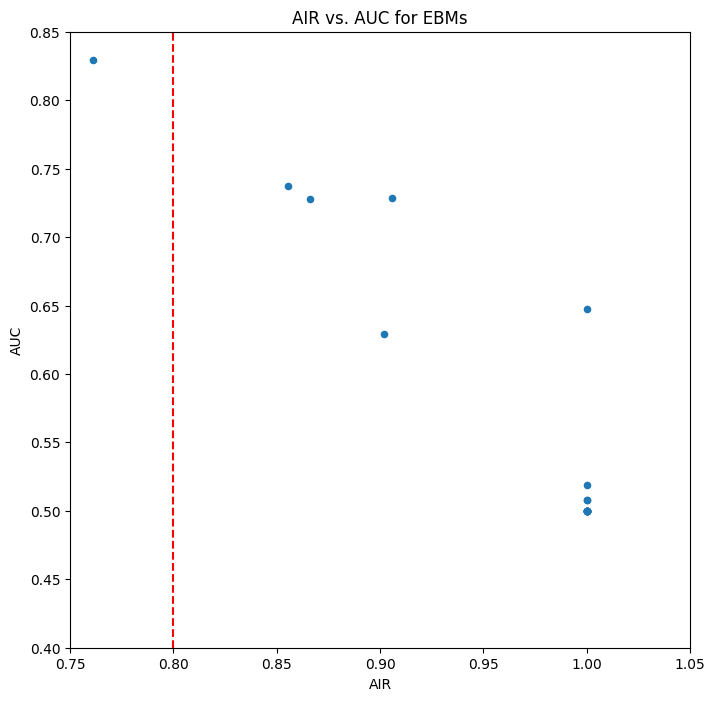

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain most accurate model above 0.8 AIR

In [ ]:
# Extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# Extract features from dict then delete from dict
rem_x_names = rem_params['features']
rem_x_names = [name.strip() for name in rem_x_names.split(',')]
del rem_params['features']

# Record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']
del rem_params['reweighting']

# Reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# Add the 'high_priced' column to the data DataFrame
data['high_priced'] = pd.Series([y_name])
data = data.dropna(subset=[y_name])

Best AUC: 0.7374 above 0.8 AIR (0.8554).


In [ ]:
print(y_name)
print(data.columns)
print(test.columns)


high_priced
Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced', 'race'],
      dtype='object')
Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'race'],
      dtype='object')


#### Check that other groups are not adversely impacted by change

In [ ]:
# Create a frame with remediated EBM predictions
probas = rem_ebm.predict_proba(valid[rem_x_names])

# Handle case where only one class is present in predictions
if probas.shape[1] == 2:
    phat = probas[:, 1]  # Probability of positive class (1)
else:
    # Only one class was present during training (likely all 0s or all 1s)
    print("Warning: Model was trained on only one class. Setting phat to zeros.")
    phat = np.zeros(len(valid))  # Or use probas[:, 0] if appropriate

best_ebm_phat2 = pd.DataFrame(phat, columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# Calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(
        best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False
    )

# Calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))


Adverse impact ratio for Asian people vs. White people: 1.000
Adverse impact ratio for Black people vs. White people: 1.000
Adverse impact ratio for Females vs. Males: 1.000


This analysis shows that even with a selective cutoff of 0.17, less discriminatory models are available. The new set of features and hyperparameters leads to a ~13% increase in AIR with a ~5% decrease in AUC.

#### Print best model parameters for later use

In [ ]:
rem_params

{'max_bins': 256,
 'max_interaction_bins': 16,
 'interactions': 15,
 'outer_bags': 8,
 'inner_bags': 4,
 'learning_rate': 0.05,
 'validation_size': 0.1,
 'min_samples_leaf': 10,
 'max_leaves': 3,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 10001}

#### Print best model features for later use  

In [ ]:
rem_x_names

['no_intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'income_std',
 'term_360',
 'conforming',
 'debt_to_income_ratio_std',
 'loan_amount_std']

#### Write submission file

In [ ]:
# Get predicted probabilities
probas = rem_ebm.predict_proba(test[rem_x_names])

# Handle case where only one class exists
if probas.shape[1] == 2:
    phat = probas[:, 1]
else:
    print("Warning: Model was trained on a single class. Assigning phat = 0.")
    phat = np.zeros(len(test))

# Save to CSV
rem_ebm_submit = pd.DataFrame(phat, columns=['phat'])
rem_ebm_submit.to_csv('ph_rem_ebm_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv', index=False)


In [ ]:
rem_x_names

['no_intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'income_std',
 'term_360',
 'conforming',
 'debt_to_income_ratio_std',
 'loan_amount_std']

#### End timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 25931.14 s.
